In [7]:
### Manual PCA Analysis
### BIOS 26211 Final Project
### Bruno Petrucci and Christian Porras

import numpy as np
import matplotlib.pyplot as plt 

In [2]:
### First create some Reference Sequence just to test the code
Nucleotides = ['A', 'T', 'C', 'G']
ReferenceSequence1 = np.array([np.random.choice(Nucleotides, 10, p=[0.25, 0.25, 0.25, 0.25])])
ReferenceSequence2 = np.array([np.random.choice(Nucleotides, 10, p=[0.25, 0.25, 0.25, 0.25])])
ReferenceSequence = np.append(ReferenceSequence1, ReferenceSequence2, axis=0)
# Of course it's unrealistic for both of them to be random but it's just for testing - this will be the reference

### Create some random sequence to compare
AnalysisSequence1 = np.array([np.random.choice(Nucleotides, 10, p=[0.25, 0.25, 0.25, 0.25])])
AnalysisSequence2 = np.array([np.random.choice(Nucleotides, 10, p=[0.25, 0.25, 0.25, 0.25])])
AnalysisSequence = np.append(AnalysisSequence1, AnalysisSequence2, axis=0)

In [3]:
### Define the function that transforms the sequence into a PCA-ble matrix
def TransformSequence(Sequence, Reference):
    Transform = np.zeros(Sequence.shape[1])
    for i in range(Sequence.shape[1]):
        if (Sequence[0][i] == Reference[0][i] and Sequence[1][i] == Reference[1][i]) or (Sequence[0][i] == Reference[1][i] and Sequence[1][i] == Reference[0][i]):
            Transform[i] = 0
        elif Sequence[0][i] == Reference[0][i] or Sequence[1][i] == Reference[1][i] or Sequence[0][i] == Reference[1][i] or Sequence[1][i] == Reference[0][i]:
            Transform[i] = 1
        else:
            Transform[i] = 2
        
    return Transform

In [4]:
### Test for the sequences generated above
print(ReferenceSequence)
print(AnalysisSequence)
TransformedSequence = TransformSequence(AnalysisSequence, ReferenceSequence)
print(TransformedSequence)

[['C' 'A' 'A' 'G' 'C' 'A' 'G' 'A' 'G' 'T']
 ['T' 'T' 'C' 'A' 'C' 'C' 'G' 'C' 'C' 'A']]
[['G' 'C' 'G' 'T' 'T' 'A' 'A' 'T' 'C' 'C']
 ['G' 'A' 'C' 'A' 'T' 'C' 'A' 'T' 'G' 'C']]
[2. 1. 1. 1. 2. 0. 2. 2. 0. 2.]


In [5]:
### Generate a bunch of sequences to test the PCA analysis
SequencesGenerated = 10
Sequences = np.array([AnalysisSequence for i in range(SequencesGenerated)])

for i in range(1,SequencesGenerated):
    NewSequence = np.array([np.random.choice(Nucleotides, 10, p=[0.25, 0.25, 0.25, 0.25])])
    Sequences[:][:][i] = NewSequence

TransformedSequences = np.zeros((SequencesGenerated, Sequences.shape[2]))

for i in range(SequencesGenerated):
    TransformedSequences[i,:] = TransformSequence(Sequences[i,:,:], ReferenceSequence)

print(TransformedSequences)

[[2. 1. 1. 1. 2. 0. 2. 2. 0. 2.]
 [2. 1. 2. 1. 0. 1. 0. 1. 2. 1.]
 [2. 2. 1. 2. 2. 1. 2. 1. 1. 2.]
 [2. 2. 1. 1. 2. 1. 2. 2. 1. 1.]
 [2. 1. 2. 2. 2. 1. 2. 2. 1. 2.]
 [2. 2. 2. 1. 2. 2. 2. 1. 1. 1.]
 [1. 1. 1. 1. 2. 1. 0. 2. 2. 2.]
 [2. 1. 1. 1. 2. 2. 2. 1. 2. 1.]
 [1. 2. 1. 2. 2. 1. 2. 2. 1. 1.]
 [1. 2. 2. 1. 0. 2. 2. 2. 2. 1.]]


[[ 0.59079586 -0.16439421]
 [-0.42902631 -0.26332424]
 [ 0.31386046  0.04488547]
 [ 0.28992672  0.19405931]
 [ 0.26517679 -0.16603357]
 [ 0.07213086  0.40423663]
 [-0.03991692 -0.67222674]
 [ 0.00632159  0.19892644]
 [ 0.27103436  0.16381836]
 [-0.36567234  0.39330623]]
[0.40339125 0.20004579]


<function matplotlib.pyplot.show(*args, **kw)>

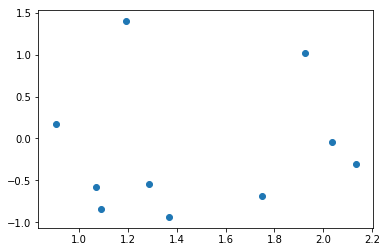

In [8]:
### Define PCA function (using code from my Lab 1)
def PCA(M, d, k):
    if (d == 0):
        Row = True
    elif (d == 1):
        Row = False
    else:
        return 0
    CovM = np.cov(M, rowvar = Row)
    eVals, eVecs = np.linalg.eig(CovM)
    CoefDet = eVals/sum(eVals)
    
    return eVecs[:,0:k], CoefDet[0:k]

PC, CoefDet = PCA(TransformedSequences, 0, 2)

print(PC)
print(CoefDet)

TransformedSequencesProj1 = TransformedSequences@PC[:, 0]
TransformedSequencesProj2 = TransformedSequences@PC[:, 1]

plt.scatter(TransformedSequencesProj1, TransformedSequencesProj2)
plt.show

In [11]:
A = np.array(range(500))
print(A[A % 100 == 0])

[  0 100 200 300 400]
